In [3]:
import numpy as np
import pandas as pd
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acf
from scipy import stats

In [4]:
# specify your outputs diretory 
output_dir = "C:/Users/singhy/Desktop/Chicago/cps_data/inflation/output"

# dataset 
data = pd.read_csv(f"{output_dir}/data/historical_data.csv")
data['date'] = pd.to_datetime(data['date']) 

In [5]:
data

,date,P_12m_change,U_rate,V_rate,tightness,ln_tightness
0,1951-01-01,7.954062,3.721283,4.118172,1.106654,0.101341
1,1951-02-01,9.402795,3.426786,3.716030,1.084407,0.081033
2,1951-03-01,9.475465,3.398586,4.085784,1.202201,0.184154
3,1951-04-01,9.598309,3.104776,4.048809,1.304058,0.265481
4,1951-05-01,9.339504,2.991425,4.085784,1.365832,0.311764
...,...,...,...,...,...,...
877,2024-02-01,3.165743,3.857226,5.263818,1.364664,0.310908
878,2024-03-01,3.475131,3.829179,4.976324,1.299580,0.262041
879,2024-04-01,3.357731,3.864677,4.714168,1.219809,0.198694
880,2024-05-01,3.250210,3.964062,4.906637,1.237780,0.213320


In [6]:
def select_optimal_var_order(df, max_lags=12):
    """
    Determine optimal VAR order using information criteria and create diagnostic plots
    
    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame with columns: 'date', 'P_12m_change', 'U_rate', 'ln_tightness'
    max_lags : int
        Maximum number of lags to consider
        
    Returns:
    --------
    dict with results and creates plots
    """
    # Set date as index if it isn't already
    if 'date' in df.columns:
        df = df.set_index('date')
    
    # Create VAR-ready dataset
    var_data = df[['P_12m_change', 'U_rate', 'ln_tightness']]
    
    # Initialize model
    model = VAR(var_data)
    
    # Calculate information criteria for different lag orders
    results = {}
    for p in range(1, max_lags + 1):
        result = model.fit(p)
        results[p] = {
            'aic': result.aic,
            'bic': result.bic,
            'hqic': result.hqic
        }
    
    # Convert results to DataFrame for easier analysis
    criteria_df = pd.DataFrame(results).T
    
    # Find optimal lags for each criterion
    optimal_lags = {
        'AIC': criteria_df['aic'].idxmin(),
        'BIC': criteria_df['bic'].idxmin(),
        'HQIC': criteria_df['hqic'].idxmin()
    }
    
    # Create plots
    fig, axes = plt.subplots(3, 1, figsize=(12, 10))
    
    # Plot information criteria
    axes[0].plot(criteria_df.index, criteria_df['aic'], marker='o', label='AIC')
    axes[0].plot(criteria_df.index, criteria_df['bic'], marker='o', label='BIC')
    axes[0].plot(criteria_df.index, criteria_df['hqic'], marker='o', label='HQIC')
    axes[0].set_xlabel('Lags')
    axes[0].set_ylabel('Criterion Value')
    axes[0].set_title('Information Criteria by Lag Order')
    axes[0].legend()
    axes[0].grid(True)
    
    # Plot the time series
    var_data['P_12m_change'].plot(ax=axes[1], title='Price Change (12m)')
    axes[1].grid(True)
    
    # Plot unemployment and tightness together (they're often related)
    ax2 = axes[2]
    ln1 = ax2.plot(var_data.index, var_data['U_rate'], 
                   color='blue', label='Unemployment Rate')
    ax2.set_ylabel('Unemployment Rate', color='blue')
    ax2.tick_params(axis='y', labelcolor='blue')
    
    ax3 = ax2.twinx()
    ln2 = ax3.plot(var_data.index, var_data['ln_tightness'], 
                   color='red', label='Log Tightness')
    ax3.set_ylabel('Log Tightness', color='red')
    ax3.tick_params(axis='y', labelcolor='red')
    
    # Add legend
    lns = ln1 + ln2
    labs = [l.get_label() for l in lns]
    ax2.legend(lns, labs, loc='upper right')
    
    plt.tight_layout()
    
    # Print results
    print("\nOptimal lag orders:")
    for criterion, lags in optimal_lags.items():
        print(f"{criterion}: {lags}")
        
    return {
        'optimal_lags': optimal_lags,
        'criteria_by_lag': criteria_df,
        'diagnostic_plots': fig
    }

C:\Users\singhy\AppData\Local\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



Optimal lag orders:
AIC: 8
BIC: 2
HQIC: 3

Detailed criteria by lag:
         aic       bic      hqic
1  -8.451410 -8.386287 -8.426507
2  -8.800125 -8.686059 -8.756504
3  -8.832343 -8.669244 -8.769968
4  -8.826840 -8.614621 -8.745675
5  -8.841761 -8.580334 -8.741770
6  -8.841600 -8.530874 -8.722746
7  -8.855753 -8.495640 -8.718002
8  -8.861033 -8.451444 -8.704347
9  -8.850387 -8.391232 -8.674731
10 -8.847544 -8.338732 -8.652880
11 -8.837451 -8.278893 -8.623743
12 -8.849517 -8.241123 -8.616729


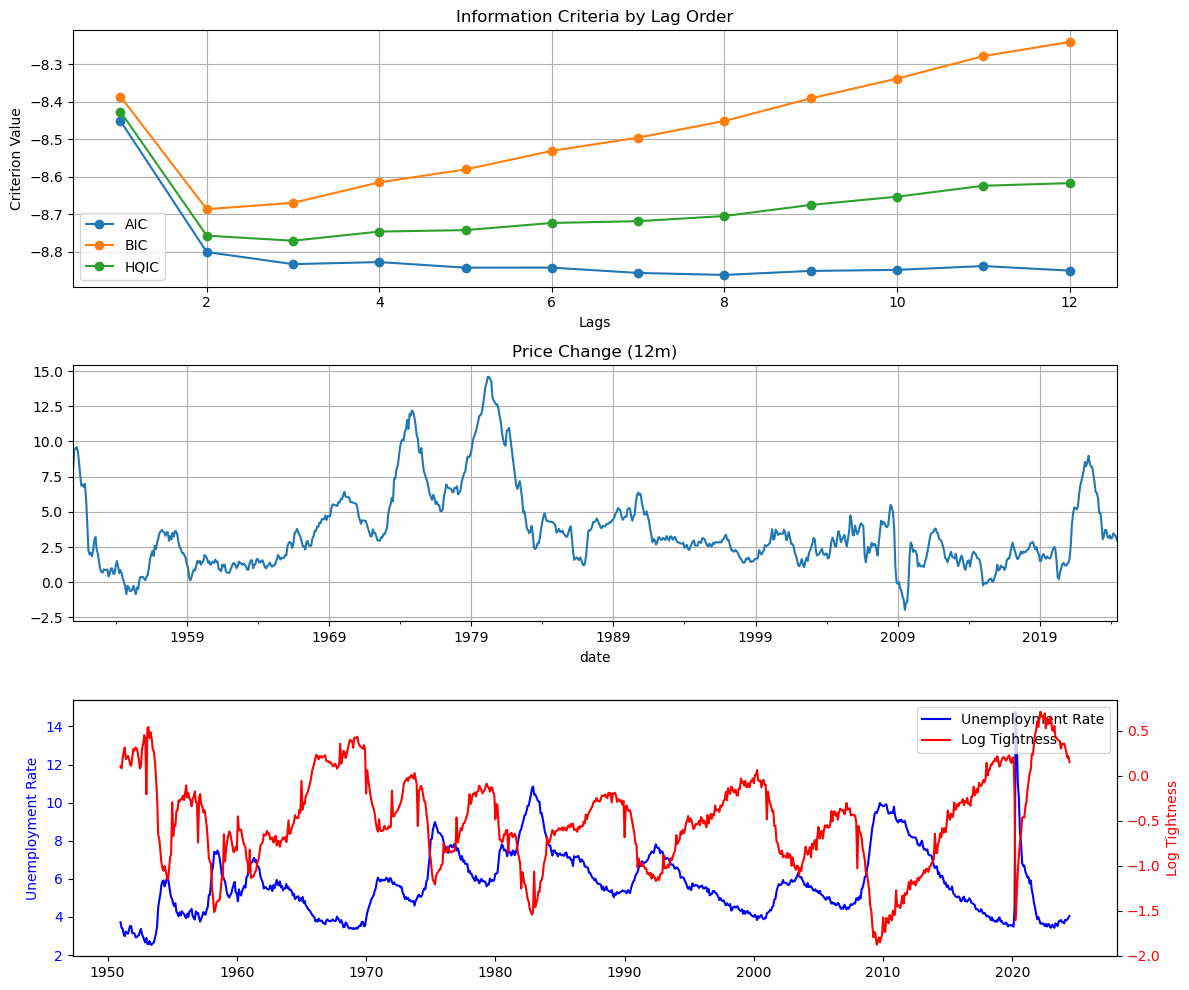

In [7]:
# Assuming your DataFrame is called 'df'
results = select_optimal_var_order(data)

# The results contain:
# - optimal_lags: dictionary with best lag order according to each criterion
# - criteria_by_lag: DataFrame with all information criteria values
# - diagnostic_plots: figure with the plots

# To view the actual values for each lag:
print("\nDetailed criteria by lag:")
print(results['criteria_by_lag'])

In [8]:
def estimate_base_var(df, order, variable_order=['P_12m_change', 'U_rate', 'ln_tightness']):
    """
    First step of VAR estimation: Get A matrices and residuals
    
    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame with your time series data
    order : int
        The chosen lag order for the VAR
    variable_order : list
        Order of variables matching the identification assumptions
        [inflation, unemployment, market tightness]
    
    Returns:
    --------
    dict containing:
        - var_result: fitted VAR model
        - A_matrices: list of coefficient matrices
        - residuals: DataFrame of residuals
        - Sigma: variance-covariance matrix of residuals
    """
    # Ensure date is index if it's not already
    if 'date' in df.columns:
        df = df.set_index('date')
    
    # Ensure variables are in correct order for identification
    data = df[variable_order]
    
    # Estimate VAR
    model = VAR(data)
    var_result = model.fit(order)
    
    # Get residuals
    residuals = pd.DataFrame(
        var_result.resid,
        index=data.index[order:],
        columns=[f"{col}_resid" for col in variable_order]
    )
    
    # Get A matrices (coefficient matrices)
    A_matrices = []
    for i in range(order):
        # Extract coefficients for lag i+1
        A_i = var_result.coefs[i]
        A_matrices.append(A_i)
    
    # Calculate variance-covariance matrix of residuals
    Sigma = np.cov(residuals.T)
    
    # Print summary statistics
    print("\nVAR Estimation Results:")
    print("----------------------")
    print(f"Number of observations: {len(residuals)}")
    print(f"Number of lags: {order}")
    print("\nResidual Correlation Matrix:")
    print(pd.DataFrame(
        np.corrcoef(residuals.T),
        columns=variable_order,
        index=variable_order
    ).round(3))
    
    print("\nResidual Standard Deviations:")
    print(residuals.std().round(3))
    
    return {
        'var_result': var_result,
        'A_matrices': A_matrices,
        'residuals': residuals,
        'Sigma': Sigma
    }

In [11]:
# Assuming your DataFrame is called 'df' and you've chosen order=2
var_results = estimate_base_var(data, order=8)

# To see the full statsmodels summary
print(var_results['var_result'].summary())

# To examine one of the A matrices (e.g., first lag)
print("\nCoefficients for first lag:")
print(pd.DataFrame(
    var_results['A_matrices'][0],
    columns=['P_12m_change', 'U_rate', 'ln_tightness'],
    index=['P_12m_change', 'U_rate', 'ln_tightness']
).round(3))


VAR Estimation Results:
----------------------
Number of observations: 874
Number of lags: 8

Residual Correlation Matrix:
              P_12m_change  U_rate  ln_tightness
P_12m_change           NaN     NaN           NaN
U_rate                 NaN     NaN           NaN
ln_tightness           NaN     NaN           NaN

Residual Standard Deviations:
P_12m_change_resid   NaN
U_rate_resid         NaN
ln_tightness_resid   NaN
dtype: float64
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 31, Oct, 2024
Time:                     15:41:30
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -8.45144
Nobs:                     874.000    HQIC:                  -8.70435
Log likelihood:           226.815    FPE:                0.000141815
AIC:                     -8.86103    Det(Omega_mle):     0.000130310
---------------------------------------

C:\Users\singhy\AppData\Local\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [36]:

class IdentifiedVAR:
    def __init__(self, n_lags):
        """
        Initialize the VAR model with specified number of lags.
        
        Parameters:
        n_lags (int): Number of lags to include in the VAR
        """
        self.n_lags = n_lags
        self.var_model = None
        self.B_matrix = None
        self.A_matrices = None
        self.residuals = None
        self.data = None
        
    def fit(self, data):
        """
        Fit the VAR model to the data.
        
        Parameters:
        data (pd.DataFrame): DataFrame with columns for inflation, U_rate, and market tightness
        """
        # Set the date as index if it's not already
        if 'date' in data.columns:
            data = data.set_index('date')
            
        # Select and rename columns if needed
        required_cols = ['inflation', 'U_rate', 'ln_tightness']
        column_mapping = {
            'P_12m_change': 'inflation',
            'U_rate': 'U_rate',
            'ln_tightness': 'ln_tightness'
        }
        
        # Rename columns if they exist in the mapping
        data = data.rename(columns=column_mapping)
        
        # Select only the required columns
        model_data = data[[col for col in required_cols if col in data.columns]]
        
        # Store the processed data
        self.data = model_data
        
        # Fit VAR model
        model = VAR(model_data)
        self.var_model = model.fit(maxlags=self.n_lags)
        
        # Store coefficient matrices
        self.A_matrices = []
        for i in range(self.n_lags):
            self.A_matrices.append(self.var_model.coefs[i])
            
        # Get residuals and compute covariance matrix
        self.residuals = self.var_model.resid
        omega_v = np.cov(self.residuals.T)
        
        # Compute B matrix using Cholesky decomposition with restrictions
        self.B_matrix = np.zeros((3, 3))
        
        # B11 = sqrt(Omega_11)
        self.B_matrix[0, 0] = np.sqrt(omega_v[0, 0])
        
        # B21 = Omega_21 / B11
        self.B_matrix[1, 0] = omega_v[1, 0] / self.B_matrix[0, 0]
        
        # B22 = sqrt(Omega_22 - B21^2)
        self.B_matrix[1, 1] = np.sqrt(omega_v[1, 1] - self.B_matrix[1, 0]**2)
        
        # B31 = Omega_31 / B11
        self.B_matrix[2, 0] = omega_v[2, 0] / self.B_matrix[0, 0]
        
        # B32 = (Omega_32 - B31*B21) / B22
        self.B_matrix[2, 1] = (omega_v[2, 1] - self.B_matrix[2, 0]*self.B_matrix[1, 0]) / self.B_matrix[1, 1]
        
        # B33 = sqrt(Omega_33 - B31^2 - B32^2)
        self.B_matrix[2, 2] = np.sqrt(omega_v[2, 2] - self.B_matrix[2, 0]**2 - self.B_matrix[2, 1]**2)
        
    def impulse_response(self, periods=20):
        """
        Compute impulse response functions.
        
        Parameters:
        periods (int): Number of periods to compute IRF for
        
        Returns:
        dict: Dictionary containing IRF matrices for each shock
        """
        n_vars = 3
        irf = np.zeros((periods, n_vars, n_vars))
        
        # Initial impact is given by B matrix
        irf[0] = self.B_matrix
        
        # Compute IRFs recursively
        for h in range(1, periods):
            for j in range(min(h, self.n_lags)):
                irf[h] += self.A_matrices[j] @ irf[h-j-1]
                
        return {
            'P_12m_change_shocks': irf[:, :, 0],
            'U_rate_shock': irf[:, :, 1],
            'tightness_shock': irf[:, :, 2]
        }
    
    def forecast(self, steps=10):
        """
        Generate forecasts from the VAR model.
        
        Parameters:
        steps (int): Number of steps ahead to forecast
        
        Returns:
        pd.DataFrame: Forecasted values
        """
        # Get the forecast
        forecast_result = self.var_model.forecast(self.var_model.endog[-self.n_lags:], steps=steps)
        
        # Create DataFrame with forecasted values
        forecast_df = pd.DataFrame(
            forecast_result,
            columns=['inflation', 'U_rate', 'ln_tightness']
        )
        
        # Set the index to continue from the last date in the original data
        last_date = self.data.index[-1]
        forecast_index = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=steps, freq='M')
        forecast_df.index = forecast_index
        
        return forecast_df


In [37]:
# Create model with desired number of lags
var_model = IdentifiedVAR(n_lags=4)  # Choose appropriate number of lags

# Fit the model
var_model.fit(data)

C:\Users\singhy\AppData\Local\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [38]:
# Get impulse responses
irf = var_model.impulse_response(periods=20)

# Generate forecasts
forecasts = var_model.forecast(steps=10)

C:\Users\singhy\AppData\Local\Temp\ipykernel_26496\2352746027.py:126: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_index = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=steps, freq='M')


In [33]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

def plot_impulse_responses(irf_dict, shock_size=13, periods=20, figsize=(15, 10)):
    """
    Plot impulse responses for all variables to a specified shock.
    
    Parameters:
    -----------
    irf_dict : dict
        Dictionary containing impulse response matrices
    shock_size : float
        Size of the shock in percentage points
    periods : int
        Number of periods to plot
    figsize : tuple
        Figure size
    """
    # Set style
    plt.style.use('seaborn')
    
    # Create figure
    fig, axes = plt.subplots(3, 1, figsize=figsize)
    fig.suptitle(f'Impulse Responses to a {shock_size}% P_12m_change Shock', fontsize=14)
    
    # Variable names and their axis positions
    variables = ['P_12m_change', 'U_rate', 'ln_tightness']
    titles = ['Response of P_12m_change', 'Response of U_rate', 'Response of Market Tightness']
    
    # Get the P_12m_change shock responses and scale them
    responses = irf_dict['P_12m_change_shock'] * shock_size
    
    # Create x-axis values
    x = np.arange(periods)
    
    # Plot each variable's response
    for i, (var, title) in enumerate(zip(variables, titles)):
        ax = axes[i]
        
        # Plot the response
        ax.plot(x, responses[:, i], 'b-', linewidth=2)
        ax.fill_between(x, 
                       responses[:, i] - 1.96 * np.std(responses[:, i]),
                       responses[:, i] + 1.96 * np.std(responses[:, i]),
                       color='b', alpha=0.1)
        
        # Add horizontal line at y=0
        ax.axhline(y=0, color='k', linestyle='--', alpha=0.3)
        
        # Customize plot
        ax.set_title(title)
        ax.set_xlabel('Months after shock')
        ax.set_ylabel('Percentage points')
        ax.grid(True, alpha=0.3)
        
        # Add peak/trough labels
        peak = np.max(responses[:, i])
        trough = np.min(responses[:, i])
        if abs(peak) > abs(trough):
            peak_time = np.argmax(responses[:, i])
            ax.annotate(f'Peak: {peak:.2f}%', 
                       xy=(peak_time, peak),
                       xytext=(10, 10),
                       textcoords='offset points')
        else:
            trough_time = np.argmin(responses[:, i])
            ax.annotate(f'Trough: {trough:.2f}%', 
                       xy=(trough_time, trough),
                       xytext=(10, -10),
                       textcoords='offset points')
    
    plt.tight_layout()
    return fig

def plot_cumulative_responses(irf_dict, shock_size=13, periods=20, figsize=(15, 10)):
    """
    Plot cumulative impulse responses for all variables to a specified shock.
    
    Parameters:
    -----------
    irf_dict : dict
        Dictionary containing impulse response matrices
    shock_size : float
        Size of the shock in percentage points
    periods : int
        Number of periods to plot
    figsize : tuple
        Figure size
    """
    # Set style
    plt.style.use('seaborn')
    
    # Create figure
    fig, axes = plt.subplots(3, 1, figsize=figsize)
    fig.suptitle(f'Cumulative Responses to a {shock_size}% P_12m_change Shock', fontsize=14)
    
    # Variable names and their axis positions
    variables = ['P_12m_change', 'U_rate', 'ln_tightness']
    titles = ['Cumulative Response of P_12m_change', 
             'Cumulative Response of U_rate', 
             'Cumulative Response of Market Tightness']
    
    # Get the P_12m_change shock responses and scale them
    responses = irf_dict['P_12m_change'] * shock_size
    
    # Compute cumulative responses
    cum_responses = np.cumsum(responses, axis=0)
    
    # Create x-axis values
    x = np.arange(periods)
    
    # Plot each variable's response
    for i, (var, title) in enumerate(zip(variables, titles)):
        ax = axes[i]
        
        # Plot the response
        ax.plot(x, cum_responses[:, i], 'r-', linewidth=2)
        ax.fill_between(x, 
                       cum_responses[:, i] - 1.96 * np.std(cum_responses[:, i]),
                       cum_responses[:, i] + 1.96 * np.std(cum_responses[:, i]),
                       color='r', alpha=0.1)
        
        # Add horizontal line at y=0
        ax.axhline(y=0, color='k', linestyle='--', alpha=0.3)
        
        # Customize plot
        ax.set_title(title)
        ax.set_xlabel('Months after shock')
        ax.set_ylabel('Cumulative percentage points')
        ax.grid(True, alpha=0.3)
        
        # Add final value label
        final_value = cum_responses[-1, i]
        ax.annotate(f'Final: {final_value:.2f}%', 
                   xy=(periods-1, final_value),
                   xytext=(10, 10),
                   textcoords='offset points')
    
    plt.tight_layout()
    return fig

In [34]:
# Get the impulse responses
irf = var_model.impulse_response(periods=20)

# Scale the inflation shock to 13%
inflation_shock = irf['P_12m_change'] * 13

# Print the responses at key horizons
print("\nResponse to 13% Inflation Shock:")
print("\nHorizon  Inflation  Unemployment  Market Tightness")
print("-------------------------------------------")
for h in [0, 3, 6, 12, 18]:
    print(f"{h:7d}  {inflation_shock[h,0]:9.2f}  {inflation_shock[h,1]:11.2f}  {inflation_shock[h,2]:14.2f}")


Response to 13% Inflation Shock:

Horizon  Inflation  Unemployment  Market Tightness
-------------------------------------------
      0       4.60        -0.43            0.06
      3       6.73        -0.50            0.05
      6       5.93         0.14           -0.10
     12       4.58         1.06           -0.32
     18       3.53         1.58           -0.45


C:\Users\singhy\AppData\Local\Temp\ipykernel_26496\2972026419.py:21: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


KeyError: 'P_12m_change_shock'

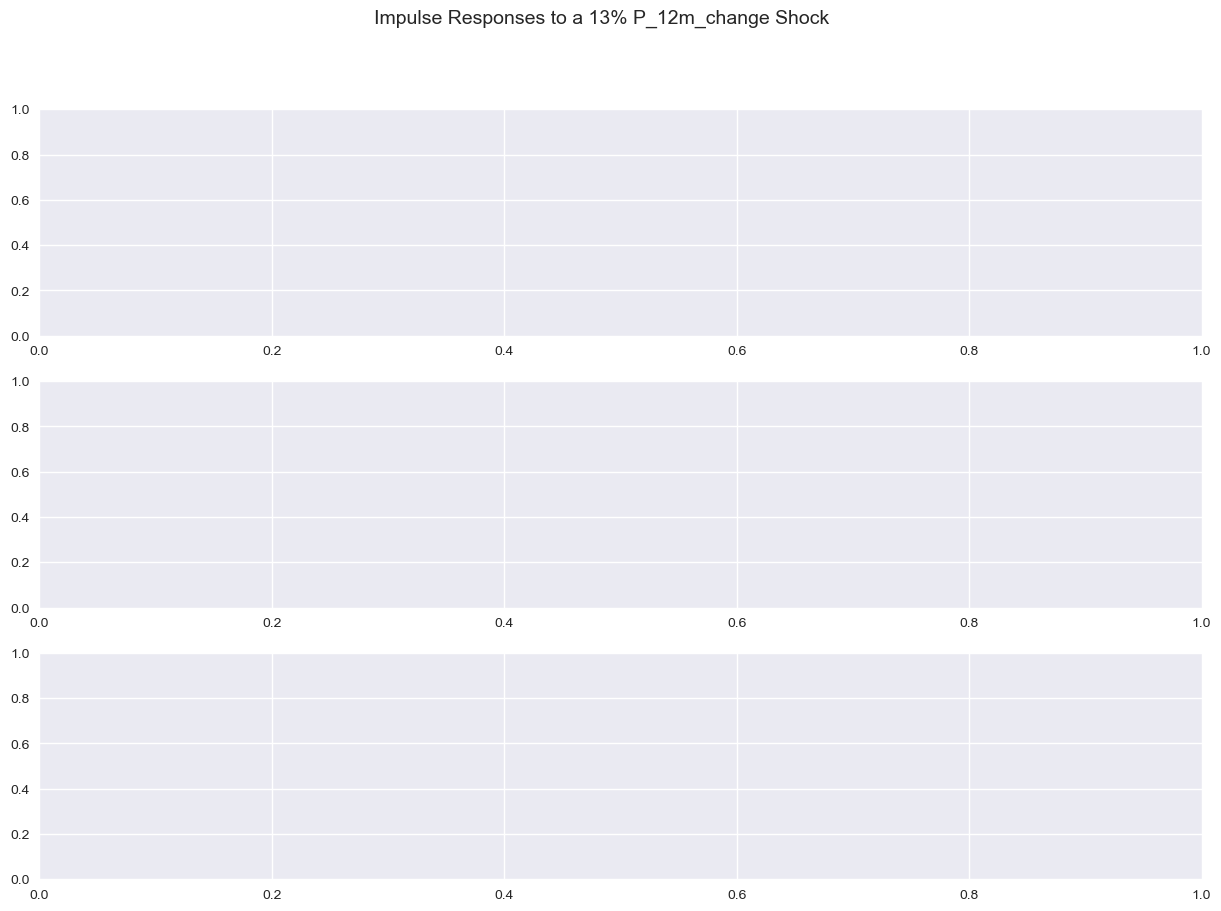

In [35]:
# Get impulse responses
irf = var_model.impulse_response(periods=20)

# Create regular impulse response plots
fig1 = plot_impulse_responses(irf, shock_size=13)

# Create cumulative response plots
fig2 = plot_cumulative_responses(irf, shock_size=13)

# Display plots
plt.show()